# Artificial Neural Networks 

### Imports

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics
import torch.optim as optim
import shap
import optuna
import pickle
import time

## Data Preparation

In [2]:
df = pd.read_csv('Data/voice.csv')
df['label'] = df['label'].replace("male", "0")
df['label'] = df['label'].replace("female", "1")
df['label'] = df['label'].astype(int)

In [3]:
train, validate, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

In [4]:
x_train = train.iloc[:,:-1]
y_train = train.label
x_test = test.iloc[:,:-1]
y_test = test.label
x_val = validate.iloc[:,:-1]
y_val = validate.label

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

In [5]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        self.length = self.x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.length

trainset = dataset(x_train, y_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=False)

testset = dataset(x_test, y_test)
testloader = DataLoader(testset, batch_size=8, shuffle=False)

valset = dataset(x_val, y_val)
valloader = DataLoader(valset, batch_size=8, shuffle=False)

## Methodology

In [6]:
# Hyper Parameters
learning_rate = 0.8601
epochs = 80
momentum = 0.2793
patience = 30
dropout_rate = 0.1801

In [20]:
class GenderClassificationModel(torch.nn.Module):    
    def __init__(self, input_shape, trials = None):
        super().__init__()
        if trials:
            learning_rate = trials.suggest_float("learning_rate", 0.0001, 1, step = 0.0001)
            epochs = trials.suggest_int("epochs", 20, 100)
            momentum = trials.suggest_float("momentum", 0.0001, 1, step = 0.0001)
            patience = trials.suggest_int("patience", 10, 50)
            dropout_rate = trials.suggest_float("dropout_rate", 0.0001, 1, step = 0.0001)
    
        self.fc1 = torch.nn.Linear(input_shape, 32)
        self.fc2 = torch.nn.Linear(32, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        if self.training:
            x = torch.nn.functional.dropout(x, dropout_rate)

        return torch.sigmoid(self.fc3(x))

In [21]:
model = GenderClassificationModel(input_shape = x_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)
loss_fn = torch.nn.BCELoss()

## Hyperparameter Optimization

In [14]:
def objective(trial):
    model = GenderClassificationModel(x_train.shape[1], trial)
    
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', "SGD"])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        for j, (x, y) in enumerate(trainloader):
            model.train()
            output = model(x)

            loss = loss_fn(output, y.reshape(-1, 1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                for j, (x, y) in enumerate(valloader):
                    output = model(x)
                    loss = loss_fn(output, y.reshape(-1, 1))

                    predicted = model(torch.tensor(x_val, dtype = torch.float32))
                    acc = (predicted.reshape(-1).detach().numpy().round() == y_val).mean()

        trial.report(acc, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return acc


In [15]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial
print(f'Accuracy: {trial.value}')
print(f'Best Hyperparameters: {trial.params}')

[I 2023-01-19 10:20:45,944] A new study created in memory with name: no-name-f77d7019-23be-46c9-b7b4-c57ae35a4cc6
[I 2023-01-19 10:23:25,980] Trial 0 finished with value: 0.9810725552050473 and parameters: {'learning_rate': 0.8569, 'epochs': 81, 'momentum': 0.2556, 'patience': 12, 'dropout_rate': 0.1851, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.9810725552050473.
[I 2023-01-19 10:26:41,215] Trial 1 finished with value: 0.9842271293375394 and parameters: {'learning_rate': 0.4602, 'epochs': 98, 'momentum': 0.1667, 'patience': 15, 'dropout_rate': 0.3257, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.9842271293375394.
[I 2023-01-19 10:29:55,395] Trial 2 finished with value: 0.9842271293375394 and parameters: {'learning_rate': 0.992, 'epochs': 63, 'momentum': 0.8996000000000001, 'patience': 49, 'dropout_rate': 0.0197, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.9842271293375394.
[I 2023-01-19 10:33:13,459] Trial 3 finished with value: 0.9747634069400631 and paramet

Accuracy: 0.9905362776025236
Best Hyperparameters: {'learning_rate': 0.8601, 'epochs': 80, 'momentum': 0.2793, 'patience': 15, 'dropout_rate': 0.1801, 'optimizer': 'Adam'}


## Training

In [22]:
train_losses = []
train_accur = []
val_losses = []
val_accur = []
test_losses = []
test_accur = []

best_val_acc = 0.0

start_timer = time.perf_counter()
for i in range(epochs):
    for j, (x, y) in enumerate(trainloader):
        model.train()
        output = model(x)

        loss = loss_fn(output, y.reshape(-1, 1))

        predicted = model(torch.tensor(x_train, dtype = torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(loss.detach().numpy())
    train_accur.append(acc)

    if i>0 and i % 10 == 0:
        print("epoch {}\ttraining_loss : {}\t training_accuracy : {}".format(i,loss,acc))
        

    model.eval()
    with torch.no_grad():
        for j, (x, y) in enumerate(valloader):
            output = model(x)
            loss = loss_fn(output, y.reshape(-1, 1))

            predicted = model(torch.tensor(x_val, dtype = torch.float32))
            acc = (predicted.reshape(-1).detach().numpy().round() == y_val).mean()

        if acc > best_val_acc:
            torch.save(model, 'Models/ANN.pth')
            best_val_acc = acc
            num_bad_epochs = 0
        else:
            num_bad_epochs += 1
            if num_bad_epochs == patience:
                break

        val_accur.append(acc)
        val_losses.append(loss)

best_model = torch.load('Models/ANN.pth')
pickle.dump(best_model, open("Models/ANN.pickle", "wb"))
end_timer = time.perf_counter()
print(f"ANN time to train: {end_timer - start_timer:0.4f} seconds")
    

epoch 10	training_loss : 0.032204002141952515	 training_accuracy : 0.978689818468824
epoch 20	training_loss : 0.005756503436714411	 training_accuracy : 0.9806629834254144
epoch 30	training_loss : 0.007721050176769495	 training_accuracy : 0.9940805051302289
epoch 40	training_loss : 0.006982761900871992	 training_accuracy : 0.9976322020520916
epoch 50	training_loss : 0.005677437409758568	 training_accuracy : 0.9964483030781374
ANN time to train: 10.5490 seconds


## Hyperparameter Optimization Evaluation
### Parameter Importance 

In [20]:
optuna.visualization.plot_param_importances(study)

## Feature Importance


## Training Evaluation
### Change is Loss over Epochs

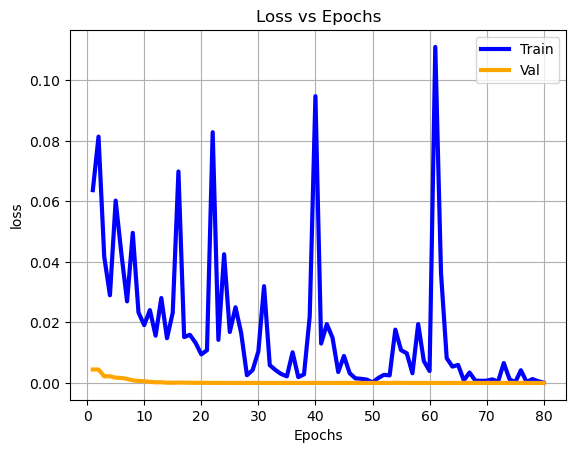

In [10]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Loss vs Epochs')
ax.plot(range(1, len(train_losses) + 1), train_losses, color='blue', linestyle='-', linewidth=3, label = "Train")
ax.plot(range(1, len(val_losses) + 1), val_losses, color='orange', linestyle='-', linewidth=3, label = "Val")
ax.legend()
ax.grid()

### Change in Accuracy over Epochs

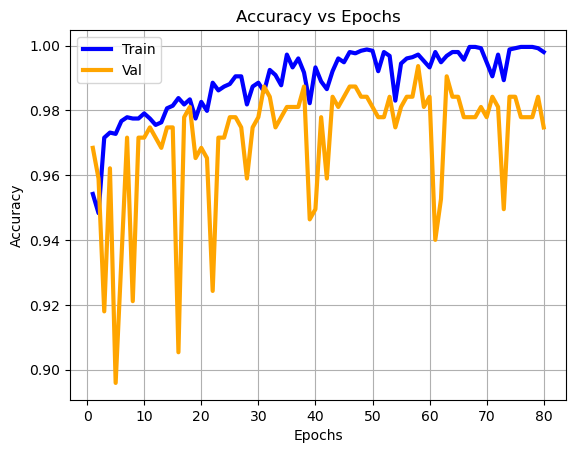

In [11]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Epochs')
ax.plot(range(1, len(train_accur) + 1), train_accur, color='blue', linestyle='-', linewidth=3, label = "Train")
ax.plot(range(1, len(val_accur) + 1), val_accur, color='orange', linestyle='-', linewidth=3, label = "Val")
ax.legend()
ax.grid()
           

## Outcome Evaluation
### Accuracy

In [12]:
with torch.no_grad():
    predicted = best_model(torch.tensor(x_test, dtype = torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == y_test).mean()
    print(f"Accuracy: {100*acc}%")

Accuracy: 98.10725552050474%


### Confusion Matrix 

In [14]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


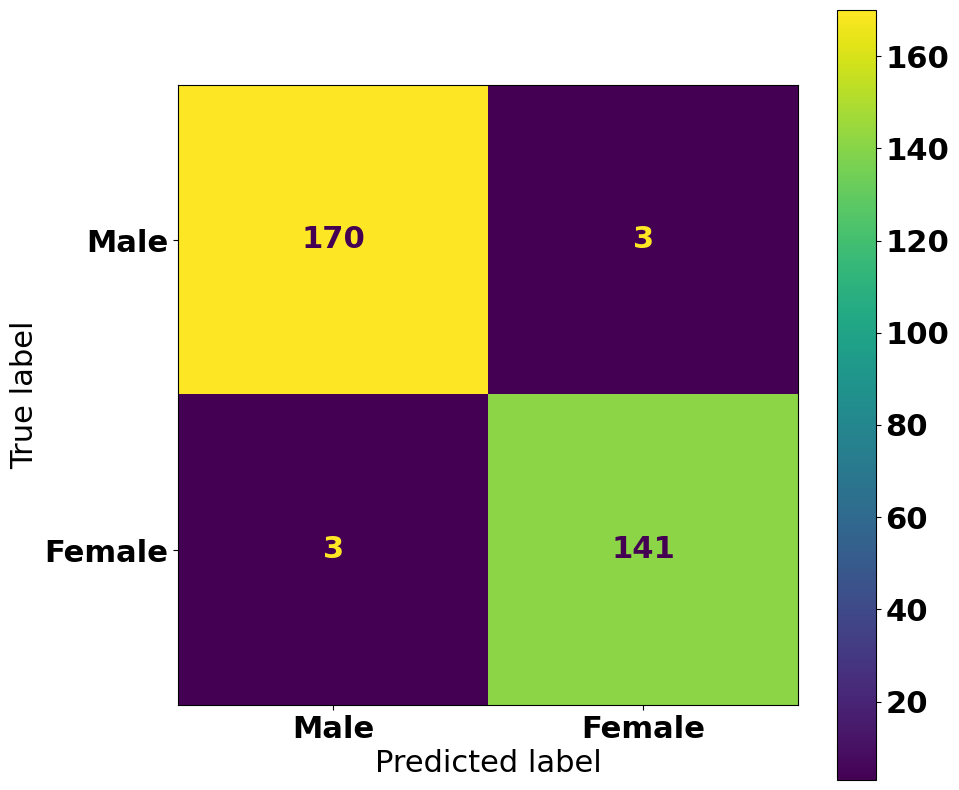

In [15]:
with torch.no_grad():
    predictions = best_model(torch.tensor(x_test, dtype = torch.float32))
    predictions = np.round(predictions.numpy())
    c = sklearn.metrics.confusion_matrix(y_test, predictions)
    cp = sklearn.metrics.ConfusionMatrixDisplay(c, display_labels=["Male", "Female"])
    fig, ax = plt.subplots(figsize=(10,10))
    cp.plot(ax = ax)

### Classification Report

In [26]:
with torch.no_grad():
    predictions = best_model(torch.tensor(x_test, dtype = torch.float32))
    predictions = np.round(predictions.numpy())
    print("\t\t\tANN report:\n",sklearn.metrics.classification_report(predictions,y_test, digits=3))

			ANN report:
               precision    recall  f1-score   support

         0.0      0.925     0.994     0.958       161
         1.0      0.993     0.917     0.953       156

    accuracy                          0.956       317
   macro avg      0.959     0.955     0.956       317
weighted avg      0.958     0.956     0.956       317

